### Running Source Extractor on HRC images

Specifically, on regions like the Lockman Hole, which have low column but lots of X-ray sources.
The goal is to prepare files that have X-ray sources (_stars_) and files that are source free (_cutout_) to later use as examples of background-free and background-dominated events.

It begins from science_dataframe, which are event 1 files with the gti mask, so unfiltered :)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import matplotlib
import os
import astropy.io.fits as fits
import heapq

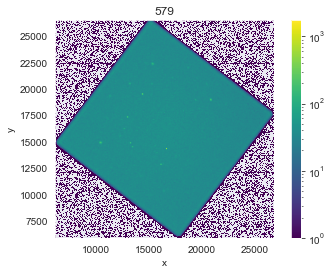

Snape (500, 500)


In [176]:
# First, choose 

obsid = 579
file_dir = "/Users/beckynevin/CfA_Code/HRC/hyperscreen/notebooks/csv_files/"
sci = pd.read_csv(file_dir+'science_dataframe_'+str(obsid)+'.csv', index_col=0)



nbins=500
x = sci['x']
y = sci['y']

img_data, yedges, xedges = np.histogram2d(y, x, nbins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# So try to figure out if you bin it up nbins times 
# how does this translate to the source extractor coordinate system
# which is [0,500 (nbins)], [0,500]

xinterval = (xedges[-1] - xedges[0])/nbins
yinterval = (yedges[-1] - yedges[0])/nbins






plt.clf()
im = plt.imshow(img_data, rasterized=True, cmap='viridis', origin='data', extent=extent, 
               norm=matplotlib.colors.LogNorm())
plt.xlabel('x')
plt.ylabel('y')

plt.colorbar()
plt.title(str(obsid))
plt.show()
print('Snape', np.shape(img_data))

In [167]:



# First step is to make an image for viewing and save as .fits file:
# Also make a weights file
def make_source_extractor_input(id, img):
    
    plt.imshow(img, norm=matplotlib.colors.LogNorm())
    plt.colorbar()
    plt.show()
    
    mask = np.zeros(np.shape(img))
    for j in range(np.shape(img)[0]):
        for i in range(np.shape(img)[1]):
            if img[j,i] > 1:
                mask[j,i] = 1
    #weights = ma.masked_where(img >10, img)
    plt.clf()
    plt.title('MASK')
    plt.imshow(mask)
    plt.colorbar()
    plt.show()
    
    
    # Save these two as .fits files:
    hdu_img = fits.PrimaryHDU(img)
    hdu_img.writeto('source/source_extractor_'+str(id)+'.fits', overwrite=True)
    
    hdu_mask = fits.PrimaryHDU(mask)
    hdu_mask.writeto('source/weight_'+str(id)+'.fits', overwrite=True)
    return img
    
    
    
def write_source_extractor(name):
    
    '''Prepares the default file for source extractor to read (I played with the parameters to the point where they work well:'''

    file = open('source/input_'+name+'.sex', "w")
    file.write('# Default configuration file for SExtractor 2.5.0'+'\n')
        
    file.write('CATALOG_NAME     source/output_'+name+'.cat       # name of the output catalog'+'\n')
    file.write('CATALOG_TYPE     ASCII_HEAD     # '+'\n')
    file.write('PARAMETERS_NAME  source/default.param  # name of the file containing catalog contents'+'\n')

    file.write('#------------------------------- Extraction ----------------------------------'+'\n')

    file.write('DETECT_TYPE      CCD            # CCD (linear) or PHOTO (with gamma correction)'+'\n')
    file.write('DETECT_MINAREA   2            # minimum number of pixels above threshold'+'\n')
    file.write('DETECT_THRESH    1.5            # <sigmas> or <threshold>,<ZP> in mag.arcsec-2'+'\n')
    file.write('ANALYSIS_THRESH  2            # <sigmas> or <threshold>,<ZP> in mag.arcsec-2'+'\n')

    file.write('FILTER           Y              # apply filter for detection (Y or N)?'+'\n')
    file.write('FILTER_NAME      source/default.conv   # name of the file containing the filter'+'\n')

    file.write('DEBLEND_NTHRESH  32             # Number of deblending sub-thresholds'+'\n')
    file.write('DEBLEND_MINCONT  0.005          # Minimum contrast parameter for deblending'+'\n')

    file.write('CLEAN            Y              # Clean spurious detections? (Y or N)?'+'\n')
    file.write('CLEAN_PARAM      1.0            # Cleaning efficiency'+'\n')

    file.write('MASK_TYPE        CORRECT        # type of detection MASKing: can be one of'+'\n')
                                # NONE, BLANK or CORRECT

    file.write('WEIGHT_TYPE      MAP_WEIGHT'+'\n')
    file.write('WEIGHT_IMAGE      source/weight_'+name+'.fits'+'\n')

    file.write('#------------------------------ Photometry -----------------------------------'+'\n')

    file.write('PHOT_APERTURES   5              # MAG_APER aperture diameter(s) in pixels'+'\n')
    file.write('PHOT_AUTOPARAMS  2.5, 3.5       # MAG_AUTO parameters: <Kron_fact>,<min_radius>'+'\n')
    file.write('PHOT_PETROPARAMS 2.0, 3.5       # MAG_PETRO parameters: <Petrosian_fact>,'+'\n')
                                # <min_radius>

    file.write('SATUR_LEVEL      50000.0        # level (in ADUs) at which arises saturation'+'\n')

    file.write('MAG_ZEROPOINT    0.0            # magnitude zero-point'+'\n')
    file.write('MAG_GAMMA        4.0            # gamma of emulsion (for photographic scans)'+'\n')
    file.write('GAIN             0.0            # detector gain in e-/ADU'+'\n')
    file.write('PIXEL_SCALE      1.0            # size of pixel in arcsec (0=use FITS WCS info)'+'\n')

    file.write('#------------------------- Star/Galaxy Separation ----------------------------'+'\n')

    file.write('SEEING_FWHM      1.2            # stellar FWHM in arcsec'+'\n')
    file.write('STARNNW_NAME     source/default.nnw    # Neural-Network_Weight table filename'+'\n')

    file.write('#------------------------------ Background -----------------------------------'+'\n')

    file.write('BACK_SIZE        30             # Background mesh: <size> or <width>,<height>'+'\n')
    file.write('BACK_FILTERSIZE  3              # Background filter: <size> or <width>,<height>'+'\n')
    file.write('BACKPHOTO_TYPE   LOCAL         # can be GLOBAL or LOCAL'+'\n')

    file.write('#------------------------------ Check Image ----------------------------------'+'\n')

    file.write('CHECKIMAGE_TYPE APERTURES         # can be NONE, BACKGROUND, BACKGROUND_RMS,'+'\n')
                                # MINIBACKGROUND, MINIBACK_RMS, -BACKGROUND,
                                # FILTERED, OBJECTS, -OBJECTS, SEGMENTATION,
                                # or APERTURES
    file.write('CHECKIMAGE_NAME  source/aps_'+name+'.fits     # Filename for the check-image'+'\n')

    file.write('#--------------------- Memory (change with caution!) -------------------------'+'\n')

    file.write('MEMORY_OBJSTACK  3000           # number of objects in stack'+'\n')
    file.write('MEMORY_PIXSTACK  300000         # number of pixels in stack'+'\n')
    file.write('MEMORY_BUFSIZE   1024           # number of lines in buffer'+'\n')

    file.write('#----------------------------- Miscellaneous ---------------------------------'+'\n')

    file.write('VERBOSE_TYPE     NORMAL         # can be QUIET, NORMAL or FULL'+'\n')
    file.write('WRITE_XML        Y              # Write XML file (Y/N)?'+'\n')
    file.write('XML_NAME         source/sex.xml        # Filename for XML output'+'\n')


    file.close()
    
def run_source_extractor(name):
    
    os.system("sex -c source/input_"+name+".sex "+"source/source_extractor_"+name+".fits")
    

def get_source_extractor_params(name, thresh):
    # all I need is the x and y position and the radius
    # but I will use flux to select the brightest 
    file_path = 'source/output_'+str(name)+'.cat'
    f = open(file_path, 'r+')
    data=f.readlines()
    
    flux_pet=[]
    x_pos=[]
    y_pos=[]
    eff_radius=[]
    
    for line in data:
        words = line.split()
        if words[0] !='#' and float(words[10]) > thresh:
            x_pos.append(float(words[1]))
            y_pos.append(float(words[2]))
            #A.append(float(words[3]))#major axis RMS
            #B.append(float(words[4]))#minor axis RMS
            eff_radius.append(float(words[8])*float(words[3]))#this is the effective radius
            flux_pet.append(float(words[10]))#flux within the petrosian aperture in counts
            
    '''
    max_i=flux_pet.index(max(flux_pet))
    x_max=x_pos[max_i]
    y_max=y_pos[max_i]
    eff_radius_max=eff_radius[max_i]
    '''
    
    return x_pos, y_pos, eff_radius, flux_pet
    

def plot_aps(save, id, xs, ys,  rad, flux):
    
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(save, norm=matplotlib.colors.LogNorm())
    im = ax.scatter(xs, ys, c=flux)
    plt.title('Input to Source Extractor')
    plt.colorbar(im)
    plt.show()
    
def cutout_events(df, xs, ys, rad, rad_thresh, id, bins, plot=False):
    # go through and make the cutouts one at a time
    
    
    index_stars = []
    for j in range(len(xs)):
        # determine the x and y range that are within this aperture:
        df_single_star = df[((df['x'] - xs[j])**2+(df['y'] - ys[j])**2) < (rad[j]*20)**2]#rad[j]
        if j == 0:
            df_stars = df_single_star
        else:
            df_stars = pd.concat([df_stars, df_single_star])
        '''
        # I think this is the slower way to do this
        for i in range(len(df)):
            if (df['x'].values[i] - xs[j])**2+(df['y'].values[i] - ys[j])**2 < rad[j]**2:# then it is within the ap:
                index_stars.append(i)
        '''
    print('number of duplicates', df_stars.duplicated(subset=['time','crsv','crsu']).sum())
    # Now delete all stars from the original dataframe:
    df_no_stars = df[~df.isin(df_stars)].dropna()
    print('original df', len(df), 'df_no_stars', len(df_no_stars), 'df_stars', len(df_stars))
    
    if plot:
        x = df_no_stars['x']
        y = df_no_stars['y']

        img_data_no_stars, yedges, xedges = np.histogram2d(y, x, bins)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

        # So try to figure out if you bin it up nbins times 
        # how does this translate to the source extractor coordinate system
        # which is [0,500 (nbins)], [0,500]

        xinterval = (xedges[-1] - xedges[0])/nbins
        yinterval = (yedges[-1] - yedges[0])/nbins
        
        plt.clf()
        fig = plt.figure(figsize=(10,5))
        ax0 = fig.add_subplot(121)
        im0 = ax0.imshow(img_data_no_stars, cmap='viridis', origin='data', extent=extent, 
                       norm=matplotlib.colors.LogNorm())#rasterized=True
        plt.colorbar(im0, fraction=0.046)
        ax0.set_title('No Stars')
        
        
        x = df_stars['x']
        y = df_stars['y']

        img_data_stars, yedges, xedges = np.histogram2d(y, x, bins, range=[[xedges[0],xedges[-1]],[yedges[0],yedges[-1]]])
        #extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

        ax1 = fig.add_subplot(122)
        im1 = ax1.imshow(img_data_stars,  cmap='viridis', origin='data', norm=matplotlib.colors.LogNorm())
        

        plt.colorbar(im1, fraction=0.046)
        ax1.set_title('Stars')
        plt.show()
    return df_stars, df_no_stars
        

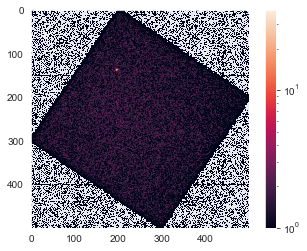

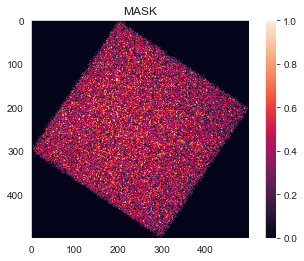

aps ([255.5648], [257.3657], [373.723], [365688.0])


<Figure size 432x288 with 0 Axes>

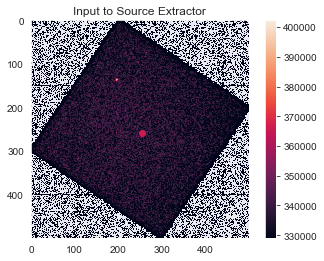

number of duplicates 0
original df 175206 df_no_stars 29228 df_stars 145930


<Figure size 432x288 with 0 Axes>

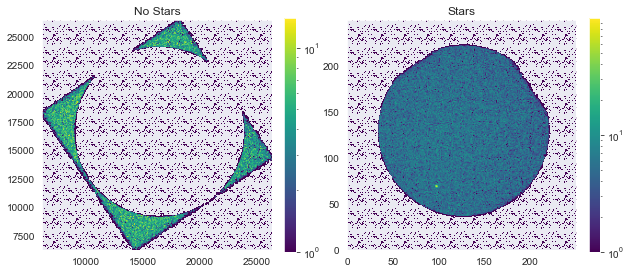

saved to file


In [175]:
# First maybe look at what's already there:
'''
se = fits.open('source/source_extractor_'+str(obsid)+'.fits')
plt.imshow(se[0].data, norm=matplotlib.colors.LogNorm())
plt.show()

aps = fits.open('source/weight_'+str(obsid)+'.fits')
plt.imshow(aps[0].data)
plt.colorbar()
plt.show()

aps = fits.open('source/aps_'+str(obsid)+'.fits')
plt.imshow(aps[0].data, norm=matplotlib.colors.LogNorm())
plt.show()
STOP
'''

save = make_source_extractor_input(obsid,img_data)



write_source_extractor(str(obsid))
run_source_extractor(str(obsid))

threshold_flux = 1

aps_out = get_source_extractor_params(obsid, threshold_flux)


print('aps',aps_out)

plot_aps(save, obsid, aps_out[0], aps_out[1], aps_out[2], aps_out[3])

xold = [xinterval * x + xedges[0] for x in aps_out[0]]
yold = [-yinterval * y + yedges[-1] for y in aps_out[1]]

xold = [xinterval * x + xedges[0] for x in aps_out[0]]
yold = [yinterval * y + yedges[0] for y in aps_out[1]]

cutout_rad = 100
#used to feed it this
df_stars, df_no_stars = cutout_events(sci, xold, yold, aps_out[2], cutout_rad, obsid, 250, plot=True)

# Now save the cutout things as such :)

file_dir = "/Users/beckynevin/CfA_Code/HRC/hyperscreen/notebooks/csv_files/"

df_no_stars.to_csv(file_dir+'science_dataframe_cutout_'+str(obsid)+'.csv')


df_stars.to_csv(file_dir+'science_dataframe_stars_'+str(obsid)+'.csv')

print('saved to file')